<a href="https://colab.research.google.com/github/Nihadkaipalli/Predictive-Modeling-for-Asteroid-and-Interstellar-Object-Collision-Risk-Using-Machine-Learning/blob/main/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Install required libraries if not already installed
!pip install imbalanced-learn xgboost scikeras[tensorflow] tensorflow

# Import libraries for model training and evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Save models
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/drive/My Drive/Asteroid Collision Dataset V2.csv'
df = pd.read_csv(file_path, low_memory=False)

# Inspect the dataset
print("Dataset Shape:", df.shape)
print("First 5 Rows:\n", df.head())


Mounted at /content/drive
Dataset Shape: (677494, 79)
First 5 Rows:
    diameter  extent  albedo  rot_per  GM  BV  UB  IR spec_B  spec_T  ...  \
0       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
1       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
2       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
3       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
4       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   

        rms  two_body  A1  A1_sigma  A2  A2_sigma  A3  A3_sigma  DT  DT_sigma  
0  0.000533       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
1  0.071263       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
2  0.000002       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
3       NaN         T NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
4  0.339380       NaN NaN       NaN NaN       NaN NaN       NaN NaN       

# 3. Data Cleaning and Preprocessing

## 3.1. Missing Data Analysis

In [3]:
# Analyze missing data
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
print(missing_summary)


Missing Data Summary (Percentage of Missing Values):
DT_sigma          100.000000
extent            100.000000
G                 100.000000
M1                100.000000
GM                100.000000
BV                100.000000
UB                100.000000
IR                100.000000
M2                100.000000
spec_T            100.000000
DT                100.000000
K1                100.000000
K2                100.000000
PC                100.000000
name               99.999852
prefix             99.999410
A3                 99.998967
A3_sigma           99.998967
A1_sigma           99.997491
A1                 99.997491
spec_B             99.992620
A2_sigma           99.976531
A2                 99.976531
n_del_obs_used     99.910700
n_dop_obs_used     99.910700
rot_per            99.801179
two_body           99.062427
albedo             99.040582
diameter_sigma     98.987002
diameter           98.986559
H_sigma            15.064635
sigma_per           0.937868
sigma_ad          

## 3.2. Drop Columns with Excessive Missing Values

In [4]:
# Drop columns with >90% missing values or irrelevant
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:")
print(df.head())


Dropped Columns:
          a         e          i          om           w         q        ad  \
0  3.344072  0.333618  17.631497  191.717418  341.109523  2.228428  4.459715   
1  2.149638  0.251325   4.728640  134.342070  281.563658  1.609380  2.689895   
2  2.320503  0.138476   6.549856  273.834058  130.418938  1.999169  2.641838   
3  2.904675  0.253684  13.139290  322.997330   64.837530  2.167804  3.641545   
4  2.257216  0.145324   4.223982  205.857738  134.532417  1.929189  2.585243   

      per_y  data_arc  condition_code  ...  sigma_w  sigma_ma  sigma_ad  \
0  6.115353      34.0             8.0  ...   1.1161   0.47857  0.032768   
1  3.151781       4.0             9.0  ...  33.7820  11.31700  0.435020   
2  3.534936      31.0             7.0  ...   2.0890  23.32100  0.004895   
3  4.950561      27.0             NaN  ...      NaN       NaN       NaN   
4  3.391313      10.0             9.0  ...  10.3150   8.20790  0.094289   

    sigma_n sigma_tp  sigma_per  class   first_obs

In [5]:
print(df.head())

          a         e          i          om           w         q        ad  \
0  3.344072  0.333618  17.631497  191.717418  341.109523  2.228428  4.459715   
1  2.149638  0.251325   4.728640  134.342070  281.563658  1.609380  2.689895   
2  2.320503  0.138476   6.549856  273.834058  130.418938  1.999169  2.641838   
3  2.904675  0.253684  13.139290  322.997330   64.837530  2.167804  3.641545   
4  2.257216  0.145324   4.223982  205.857738  134.532417  1.929189  2.585243   

      per_y  data_arc  condition_code  ...  sigma_w  sigma_ma  sigma_ad  \
0  6.115353      34.0             8.0  ...   1.1161   0.47857  0.032768   
1  3.151781       4.0             9.0  ...  33.7820  11.31700  0.435020   
2  3.534936      31.0             7.0  ...   2.0890  23.32100  0.004895   
3  4.950561      27.0             NaN  ...      NaN       NaN       NaN   
4  3.391313      10.0             9.0  ...  10.3150   8.20790  0.094289   

    sigma_n sigma_tp  sigma_per  class   first_obs    last_obs      

In [6]:
# Missing Data Analysis
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
print(missing_summary)


Missing Data Summary (Percentage of Missing Values):
H_sigma           15.064635
sigma_ad           0.937868
sigma_per          0.937868
pha                0.937720
moid_ld            0.937573
moid               0.937573
sigma_e            0.937573
sigma_a            0.937573
sigma_q            0.937573
sigma_i            0.937573
sigma_om           0.937573
sigma_w            0.937573
sigma_ma           0.937573
moid_jup           0.937573
sigma_n            0.937573
sigma_tp           0.937573
data_arc           0.392771
H                  0.146717
condition_code     0.001033
t_jup              0.000295
neo                0.000295
per_y              0.000295
ad                 0.000295
per                0.000295
rms                0.000148
dtype: float64


## 3.3. Convert Columns to Numeric

In [7]:
from sklearn.impute import SimpleImputer

# Convert columns to numeric where possible
columns_to_clean = ['H', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'n']
for col in columns_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

## 3.4. Impute Missing Values

In [8]:
# Impute missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 3. Feature Engineering

## 3.1. Binary Mapping

In [9]:
# Map binary columns
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)

## 3.2. Handle Dates

In [10]:
# Handle date columns
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)

In [11]:
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Date conversion:", remaining_categorical_cols)


Remaining Categorical Columns after Date conversion: ['class']


## 3.3. One-Hot Encoding

In [12]:
#Identify Remaining Categorical Columns
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Binary Mapping:", remaining_categorical_cols)


Remaining Categorical Columns after Binary Mapping: ['class']


In [13]:
# One-hot encode the 'class' column
if 'class' in df.columns:
    df = pd.get_dummies(df, columns=['class'], prefix='class', drop_first=True)

In [14]:
# Check unique values in the 'class' column
if 'class' in df.columns:
    print("Unique values in 'class' column:", df['class'].unique())

## 3.4. Derive New Features

In [15]:
GRAVITATIONAL_CONSTANT = 39.478

# Add derived features
df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']

# Perturbed features
for col in ['a', 'e', 'q', 'i']:
    sigma_col = f'sigma_{col}'
    if sigma_col in df.columns:
        df[f'{col}_perturbed'] = df[col] + np.random.normal(0, df[sigma_col])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


#4. Define Features and Target

## 4.1. Create Collision Risk

In [16]:
# Create collision_risk based on MOID
df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)

In [17]:
# Check if collision_risk was created successfully
print(df[['moid', 'collision_risk']])

            moid  collision_risk
0       1.240420               0
1       0.629025               0
2       1.015530               0
3       1.230665               0
4       0.923138               0
...          ...             ...
677489  0.272574               0
677490  0.000087               1
677491  0.816015               0
677492  0.672539               0
677493  0.036665               1

[677494 rows x 2 columns]


## 4.2. Define Features (X) and Target (y)

In [18]:
# Define features and target
features_to_drop = ['moid', 'moid_ld']  # Exclude MOID-related features
X = df.drop(columns=features_to_drop + ['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features
X = X.select_dtypes(include=[np.number])

# 5. Data Splitting and Scaling

## 5.1. Split Dataset

In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Drop Columns With All Missing Values

In [20]:
# Identify and drop columns with all missing values
all_missing_cols = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", all_missing_cols)

X_train = X_train.drop(columns=all_missing_cols)
X_test = X_test.drop(columns=all_missing_cols)

Columns with all missing values: Index(['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year',
       'tp_cal_month', 'tp_cal_day'],
      dtype='object')


## 5.2 Reimpute Missing values

In [21]:

# Re-impute missing values in training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Missing Values in X_train: 0
Missing Values in X_test: 0


## 5.3. Resample Using SMOTE

In [22]:
!pip install imbalanced-learn

In [23]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Set Shape:", X_train_resampled.shape, y_train_resampled.shape)

Resampled Training Set Shape: (1054508, 50) (1054508,)


In [24]:
# Verify the class distribution
print("Class Distribution After Resampling:\n", pd.Series(y_train_resampled).value_counts())

Class Distribution After Resampling:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


In [25]:
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-Numeric Columns in X_train:", non_numeric_cols)

Non-Numeric Columns in X_train: []


In [26]:
print("Missing Values in the Entire Dataset:\n", df.isnull().sum())

Missing Values in the Entire Dataset:
 a                 0
e                 0
i                 0
om                0
w                 0
                 ..
a_perturbed       0
e_perturbed       0
q_perturbed       0
i_perturbed       0
collision_risk    0
Length: 68, dtype: int64


## 5.4 Feature Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Train the Model

In [29]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train the model on the resampled and scaled training data
rf_model.fit(X_train_resampled_scaled, y_train_resampled)

print("Random Forest training completed.")

Random Forest training completed.


## Evaluate the Model

In [30]:
# Make predictions on the scaled test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9955    0.9975    131814
           1     0.8586    0.9872    0.9185      3685

    accuracy                         0.9952    135499
   macro avg     0.9291    0.9914    0.9580    135499
weighted avg     0.9958    0.9952    0.9954    135499

Random Forest Confusion Matrix:
[[131215    599]
 [    47   3638]]
Random Forest Accuracy: 0.9952324371397575


## Feature Importance

Top 10 Most Important Features (Random Forest):
             Feature  Importance
5                  q    0.202790
13               neo    0.166652
48       q_perturbed    0.161210
11                 H    0.089689
20                 n    0.052812
7              per_y    0.046325
44  orbital_velocity    0.041173
47       e_perturbed    0.032660
22               per    0.032444
46       a_perturbed    0.031978


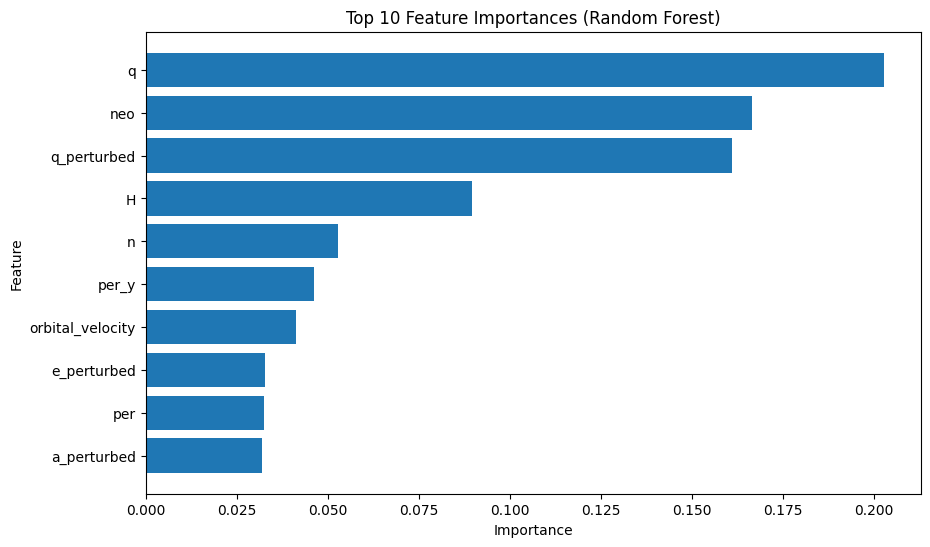

In [33]:
import matplotlib.pyplot as plt
# Feature importance analysis
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'][:10], feature_importance_rf['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Gradient Boosting Classifier (XGBoost)

In [34]:
# Install XGBoost if not already installed
!pip install xgboost

# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

##  Train the Model

In [35]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1  # Adjust if necessary
)

# Train the model on the resampled and scaled training data
xgb_model.fit(X_train_resampled_scaled, y_train_resampled)

print("XGBoost training completed.")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:36:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training completed.


## Evaluate the Model

In [36]:
# Make predictions on the scaled test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9972    0.9982    131814
           1     0.9057    0.9723    0.9378      3685

    accuracy                         0.9965    135499
   macro avg     0.9525    0.9847    0.9680    135499
weighted avg     0.9967    0.9965    0.9966    135499

XGBoost Confusion Matrix:
[[131441    373]
 [   102   3583]]
XGBoost Accuracy: 0.9964944390733511


## Feature Importance

Top 10 Most Important Features (XGBoost):
                      Feature  Importance
5                           q    0.904331
48                q_perturbed    0.030827
14                        pha    0.022257
13                        neo    0.006508
11                          H    0.004867
43  relative_orbital_distance    0.003315
9              condition_code    0.002372
7                       per_y    0.001929
41             last_obs_month    0.001708
49                i_perturbed    0.001238


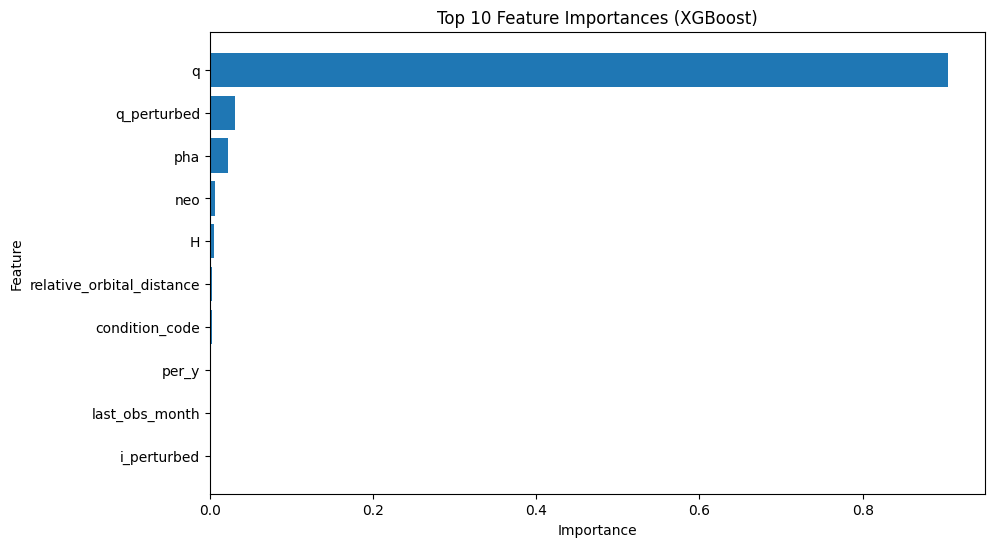

In [37]:
# Feature importance analysis
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['Feature'][:10], feature_importance_xgb['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Custom Neural Network

##  Build and Train the Model

In [40]:
# Initialize the neural network
nn_model = Sequential()

# Input layer
nn_model.add(Dense(128, activation='relu', input_shape=(X_train_resampled_scaled.shape[1],)))

# Hidden layers with Dropout for regularization
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))

# Output layer
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(
    X_train_resampled_scaled, y_train_resampled,
    epochs=10,
    batch_size=256,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

print("Neural Network training completed.")

Epoch 1/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.9835 - loss: 0.0519 - val_accuracy: 0.9910 - val_loss: 0.0255
Epoch 2/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - accuracy: 0.9948 - loss: 0.0191 - val_accuracy: 0.9926 - val_loss: 0.0230
Epoch 3/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9959 - loss: 0.0151 - val_accuracy: 0.9932 - val_loss: 0.0217
Epoch 4/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9961 - loss: 0.0145 - val_accuracy: 0.9936 - val_loss: 0.0208
Epoch 5/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9963 - loss: 0.0140 - val_accuracy: 0.9939 - val_loss: 0.0195
Epoch 6/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9963 - loss: 0.0137 - val_accuracy: 0.9940 - val_loss: 0.0176
Epoch 7/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9964 - loss: 0.0137 - val_accuracy: 0.9938 - val_loss: 0.0209
Epoch 8/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9966 - loss:

## Evaluate the Model

In [41]:
# Make predictions on the test set
y_pred_nn_prob = nn_model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).flatten()

# Evaluate the model
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn, digits=4))

print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

# Accuracy score
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)

4235/4235 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9945    0.9971    131814
           1     0.8344    0.9927    0.9067      3685

    accuracy                         0.9944    135499
   macro avg     0.9171    0.9936    0.9519    135499
weighted avg     0.9953    0.9944    0.9947    135499

Neural Network Confusion Matrix:
[[131088    726]
 [    27   3658]]
Neural Network Accuracy: 0.9944427634152282


## Plot Training History

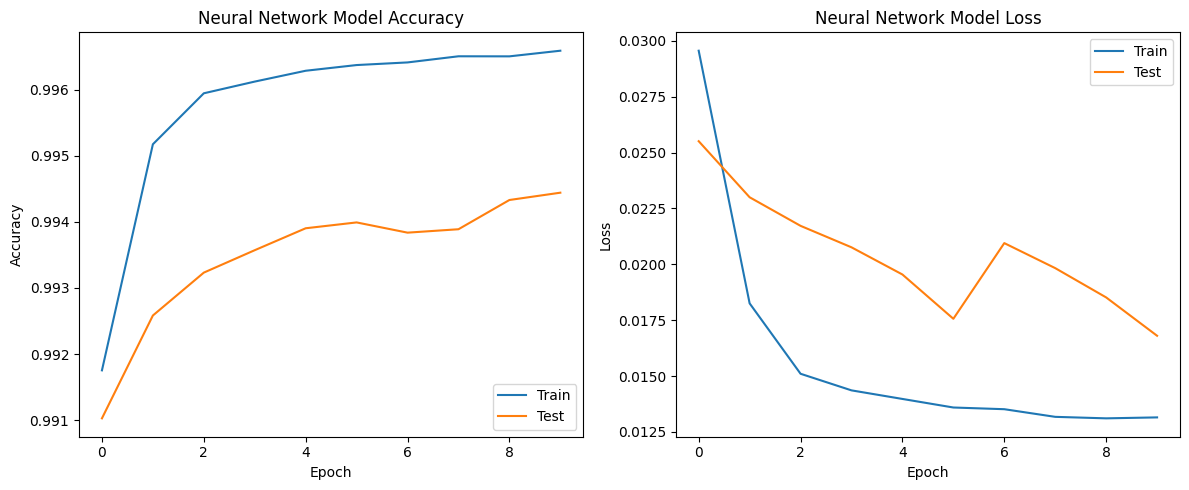

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Neural Network Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Model Evaluation and Comparison

## Extract Metrics for Minority Class

In [43]:
# Function to extract metrics for the minority class
def get_minority_class_metrics(report):
    lines = report.strip().split('\n')
    for line in lines[2:]:
        if line.strip().startswith('1 '):
            values = line.strip().split()
            precision = float(values[1])
            recall = float(values[2])
            f1_score = float(values[3])
            support = int(values[4])
            return precision, recall, f1_score, support

## Compile Metrics for Comparison

In [44]:
# Extract metrics
models = ['Random Forest', 'XGBoost', 'Neural Network']
reports = [classification_report(y_test, y_pred_rf, digits=4),
           classification_report(y_test, y_pred_xgb, digits=4),
           classification_report(y_test, y_pred_nn, digits=4)]

metrics = []
for model_name, report in zip(models, reports):
    precision, recall, f1_score, support = get_minority_class_metrics(report)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })

# Create DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the comparison
print("\nComparison of Models on Minority Class Metrics:")
print(metrics_df)


Comparison of Models on Minority Class Metrics:
            Model  Precision  Recall  F1-Score  Support
0   Random Forest     0.8586  0.9872    0.9185     3685
1         XGBoost     0.9057  0.9723    0.9378     3685
2  Neural Network     0.8344  0.9927    0.9067     3685


## Visualize Metrics

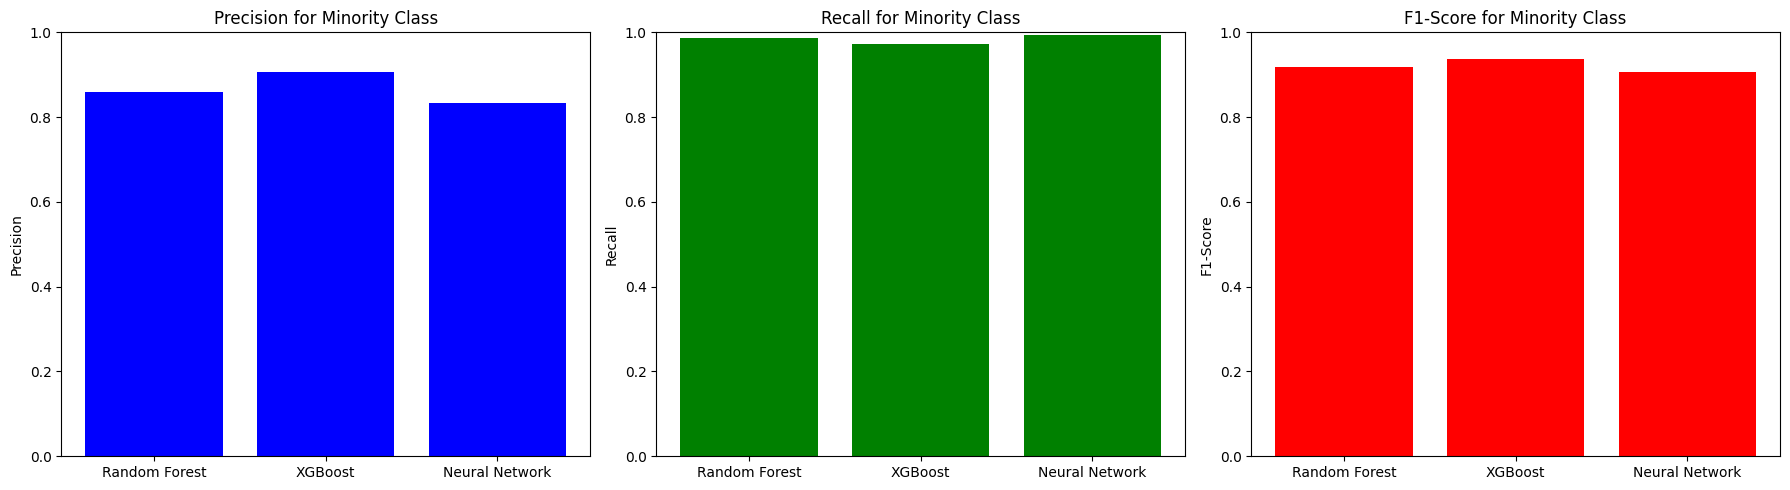

In [45]:
# Plotting the metrics for comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Precision
ax[0].bar(metrics_df['Model'], metrics_df['Precision'], color='blue')
ax[0].set_title('Precision for Minority Class')
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('Precision')

# Recall
ax[1].bar(metrics_df['Model'], metrics_df['Recall'], color='green')
ax[1].set_title('Recall for Minority Class')
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Recall')

# F1-Score
ax[2].bar(metrics_df['Model'], metrics_df['F1-Score'], color='red')
ax[2].set_title('F1-Score for Minority Class')
ax[2].set_ylim([0, 1])
ax[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()